In [1]:
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Google Drive ID for the Parquet file
file_id = "1gLPWgUGtRb371Gpv5O8t5j95lthNjELg"
url = f"https://drive.google.com/uc?id={file_id}"
output = "sm2_public_dataset.parquet"

# Download
gdown.download(url, output, quiet=False)

# Load
df = pd.read_parquet(output)

Downloading...
From: https://drive.google.com/uc?id=1gLPWgUGtRb371Gpv5O8t5j95lthNjELg
To: /content/sm2_public_dataset.parquet
100%|██████████| 1.29M/1.29M [00:00<00:00, 20.3MB/s]


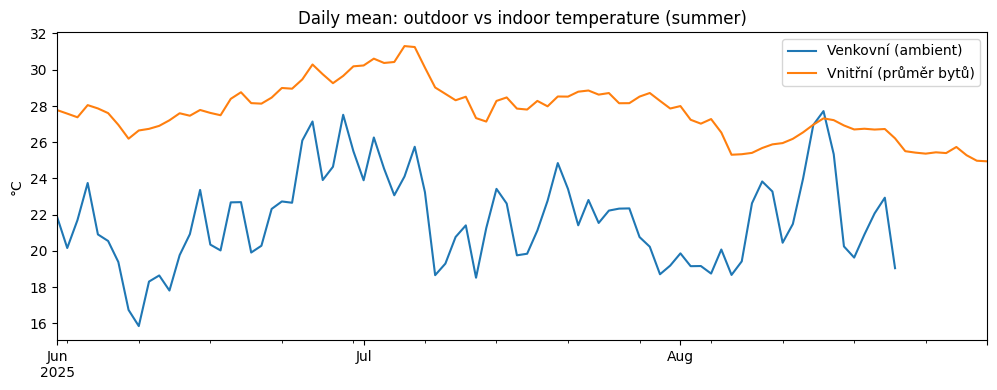

In [2]:
# Summer (inclusive edges) – adjust as needed
SUMMER_START = "2025-06-01"
SUMMER_END   = "2025-08-31 23:59:59"
# ---------------------------
# Basic cleaning
# ---------------------------
df["time"] = pd.to_datetime(df["time"], utc=True, errors="coerce")
df = df.dropna(subset=["time", "data_value", "source", "data_key", "location"])
df = df.sort_values("time")

# Summer
summer = df[(df["time"] >= pd.Timestamp(SUMMER_START, tz="UTC")) &
            (df["time"] <= pd.Timestamp(SUMMER_END, tz="UTC"))].copy()

# Location helpers (PP/NP, floor number, sections S1..S9)
def parse_location(loc: str):
    # expects a format like "1NP-S5" or "2PP-S1"
    try:
        floor_part, section = loc.split("-")
        # floor_part e.g. "1NP" / "2PP"
        if "PP" in floor_part:
            level = -int(''.join([c for c in floor_part if c.isdigit()]))  # podzemí jako záporné
            zone = "PP"
        elif "NP" in floor_part:
            level = int(''.join([c for c in floor_part if c.isdigit()]))
            zone = "NP"
        else:
            # aggregated VZT sections (e.g., sm2_01)
            level, zone = np.nan, "VZT"
        return pd.Series({"floor_level": level, "zone": zone, "section": section})
    except Exception:
        # e.g., sm2_01 (Atrea)
        return pd.Series({"floor_level": np.nan, "zone": "VZT", "section": "ALL"})

loc_meta = summer["location"].apply(parse_location)
summer = pd.concat([summer, loc_meta], axis=1)

# Split sources for convenience
atrea = summer[summer["source"] == "Atrea"].copy()
thermo = summer[summer["source"] == "ThermoPro"].copy()

# ---------------------------
# 1) Časové řady: venkovní vs. průměr vnitřní (denní)
# ---------------------------
# outdoor (ambient): Atrea temp_ambient — average globally (sections sm2_0x)
amb = atrea[atrea["data_key"] == "temp_ambient"].groupby("time")["data_value"].mean()
amb_daily = amb.resample("D").mean()

# indoor: ThermoPro temp_indoor — mean across all flats
indoor_all = thermo[thermo["data_key"] == "temp_indoor"].groupby("time")["data_value"].mean()
indoor_daily = indoor_all.resample("D").mean()

plt.figure(figsize=(12,4))
amb_daily.plot()
indoor_daily.plot()
plt.title("Daily mean: outdoor vs indoor temperature (summer)")
plt.xlabel("")
plt.ylabel("°C")
plt.legend(["Venkovní (ambient)", "Vnitřní (průměr bytů)"])
plt.show()

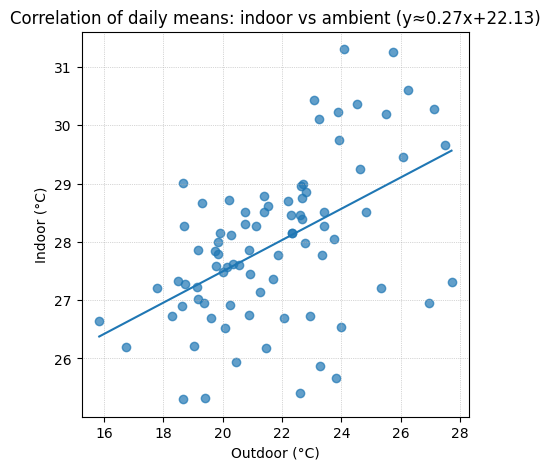

In [3]:
# ---------------------------
# 2) Correlation: scatter + linear regression (daily means)
# ---------------------------
corr_df = pd.DataFrame({"ambient": amb_daily, "indoor": indoor_daily}).dropna()
x = corr_df["ambient"].values
y = corr_df["indoor"].values

# regression (y = a*x + b)
a, b = np.polyfit(x, y, 1)
x_line = np.linspace(x.min(), x.max(), 100)
y_line = a * x_line + b

plt.figure(figsize=(5,5))
plt.scatter(x, y, alpha=0.7)
plt.plot(x_line, y_line)
plt.title(f"Correlation of daily means: indoor vs ambient (y≈{a:.2f}x+{b:.2f})")
plt.xlabel("Outdoor (°C)")
plt.ylabel("Indoor (°C)")
plt.grid(True, linestyle=":", linewidth=0.5)
plt.show()

/tmp/ipython-input-2960127897.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_PP, data_NP], labels=["PP", "NP"], showfliers=False)


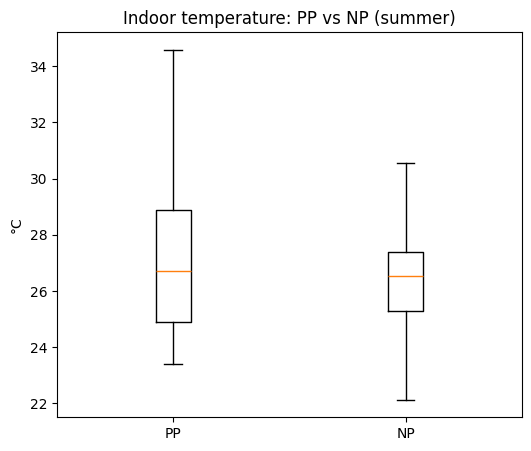

In [4]:
# ---------------------------
# 3) Rozdíly podle zóny: PP vs. NP (boxplot)
# ---------------------------
indoor_points = thermo[thermo["data_key"] == "temp_indoor"].dropna(subset=["data_value"])
indoor_points = indoor_points[indoor_points["zone"].isin(["PP", "NP"])]

data_PP = indoor_points[indoor_points["zone"] == "PP"]["data_value"].values
data_NP = indoor_points[indoor_points["zone"] == "NP"]["data_value"].values

plt.figure(figsize=(6,5))
plt.boxplot([data_PP, data_NP], labels=["PP", "NP"], showfliers=False)
plt.title("Indoor temperature: PP vs NP (summer)")
plt.ylabel("°C")
plt.show()

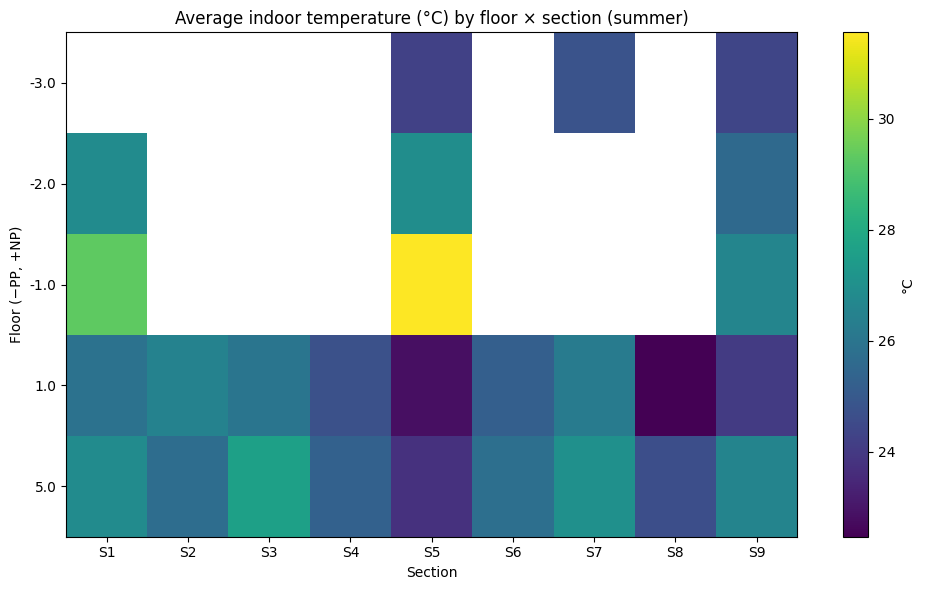

In [5]:
# ---------------------------
# 4) Heatmapa: průměrná vnitřní teplota podle podlaží a sekce
# ---------------------------
heat = thermo[(thermo["data_key"]=="temp_indoor") & thermo["zone"].isin(["PP","NP"])].copy()
heat_mean = heat.groupby(["floor_level","section"])["data_value"].mean().unstack("section")

# Sort floors from lowest (PP negative) to highest
heat_mean = heat_mean.sort_index()

plt.figure(figsize=(10,6))
plt.imshow(heat_mean.values, aspect="auto")
plt.title("Average indoor temperature (°C) by floor × section (summer)")
plt.yticks(ticks=np.arange(len(heat_mean.index)), labels=[str(i) for i in heat_mean.index])
plt.xticks(ticks=np.arange(len(heat_mean.columns)), labels=heat_mean.columns, rotation=0)
plt.colorbar(label="°C")
plt.xlabel("Section")
plt.ylabel("Floor (−PP, +NP)")
plt.tight_layout()
plt.show()

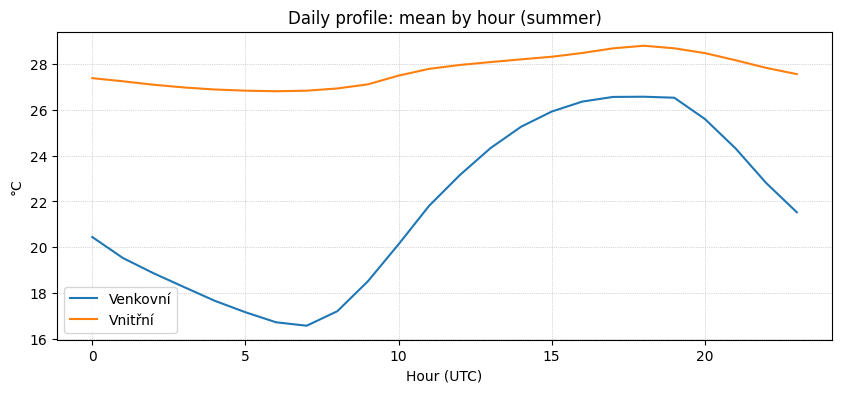

In [6]:
# ---------------------------
# 5) Denní cyklus (0–23): venek vs. byty (letní průměr po hodinách)
# ---------------------------
def hourly_profile(series: pd.Series):
    s = series.copy()
    s.index = s.index.tz_convert("UTC")  # jistota stejného TZ
    return s.groupby(s.index.hour).mean()

amb_hour = hourly_profile(amb)
indoor_hour = hourly_profile(indoor_all)

plt.figure(figsize=(10,4))
amb_hour.plot()
indoor_hour.plot()
plt.title("Daily profile: mean by hour (summer)")
plt.xlabel("Hour (UTC)")
plt.ylabel("°C")
plt.legend(["Venkovní", "Vnitřní"])
plt.grid(True, linestyle=":", linewidth=0.5)
plt.show()

/tmp/ipython-input-597188884.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  amb_h = amb.resample("H").mean()
/tmp/ipython-input-597188884.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ind_h = indoor_all.resample("H").mean()


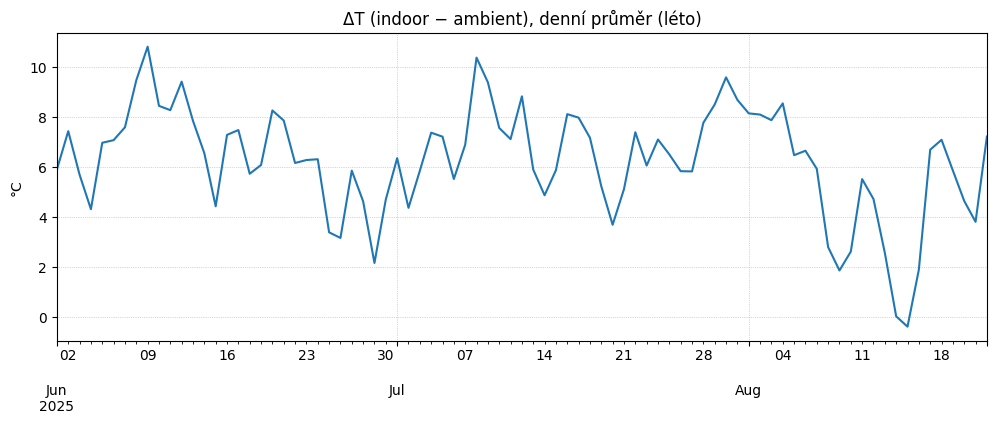

In [7]:
# ---------------------------
# 6) ΔT = indoor − ambient (denní průměr)
# ---------------------------
# For ΔT it is good to align by time — use hourly means then daily
amb_h = amb.resample("H").mean()
ind_h = indoor_all.resample("H").mean()
dtemp = (ind_h - amb_h).dropna()
dtemp_daily = dtemp.resample("D").mean()

plt.figure(figsize=(12,4))
dtemp_daily.plot()
plt.title("ΔT (indoor − ambient), denní průměr (léto)")
plt.xlabel("")
plt.ylabel("°C")
plt.grid(True, linestyle=":", linewidth=0.5)
plt.show()

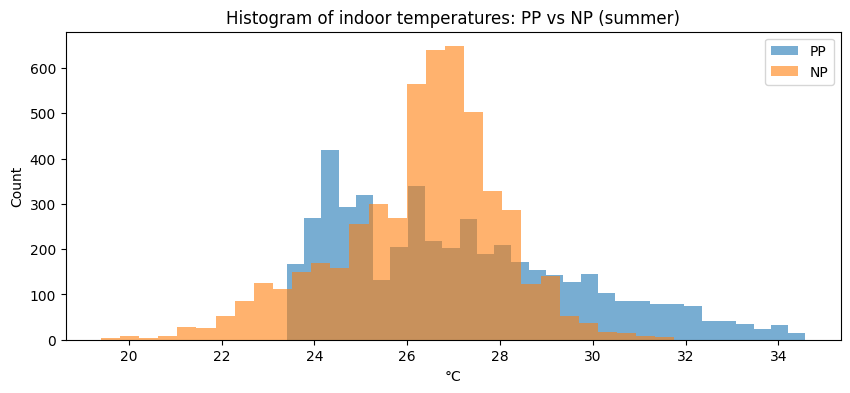

In [8]:
# ---------------------------
# 7) Histogramy vnitřních teplot (PP vs. NP)
# ---------------------------
plt.figure(figsize=(10,4))
plt.hist(data_PP, bins=30, alpha=0.6, label="PP")
plt.hist(data_NP, bins=30, alpha=0.6, label="NP")
plt.title("Histogram of indoor temperatures: PP vs NP (summer)")
plt.xlabel("°C")
plt.ylabel("Count")
plt.legend()
plt.show()

/tmp/ipython-input-507468392.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


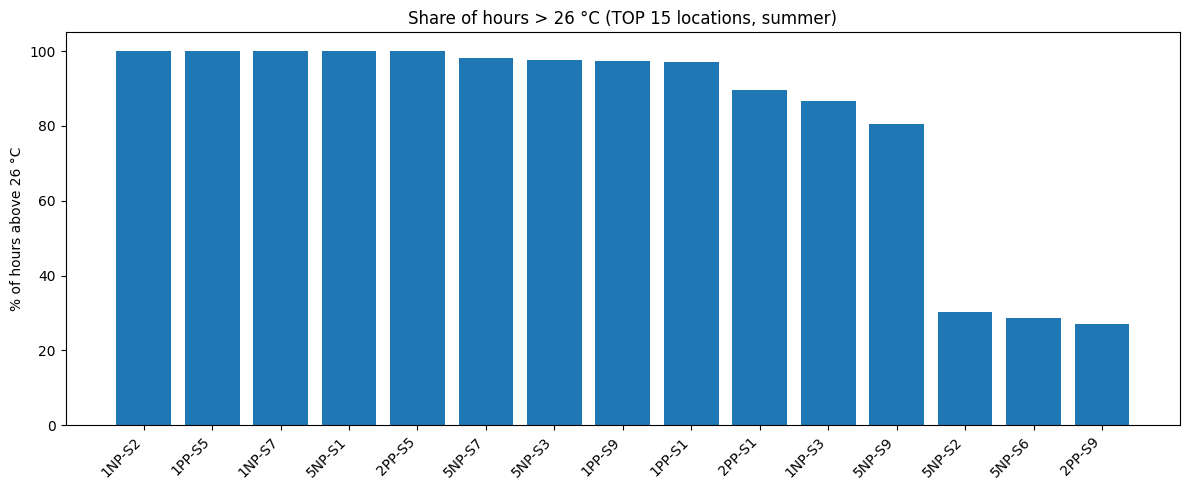

In [9]:
# ---------------------------
# 8) Překročení 26 °C: podíl hodin nad limitem (TOP 15 lokací)
# ---------------------------
limit = 26.0
indoor_by_loc = thermo[thermo["data_key"]=="temp_indoor"].copy()
by_loc = (indoor_by_loc
          .groupby(["location"])
          .apply(lambda g: pd.Series({
              "hours_total": g["data_value"].shape[0],
              "hours_over": (g["data_value"] > limit).sum(),
          })))
by_loc["share_over_%"] = 100 * by_loc["hours_over"] / by_loc["hours_total"]
top = by_loc.sort_values("share_over_%", ascending=False).head(15)

plt.figure(figsize=(12,5))
plt.bar(top.index, top["share_over_%"].values)
plt.title("Share of hours > 26 °C (TOP 15 locations, summer)")
plt.ylabel("% of hours above 26 °C")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [10]:
# ---------------------------
# Info o rozsahu vstupu
# ---------------------------
print("Časový rozsah léta v datech:", summer["time"].min(), "→", summer["time"].max())
print("Počet záznamů (léto):", len(summer))
print("Počet bytových lokací (ThermoPro):", thermo["location"].nunique())
print("VZT sekce (Atrea):", atrea["location"].unique())

Časový rozsah léta v datech: 2025-06-01 00:00:00+00:00 → 2025-08-31 23:00:00+00:00
Počet záznamů (léto): 93004
Počet bytových lokací (ThermoPro): 27
VZT sekce (Atrea): ['sm2_05' 'sm2_07' 'sm2_06' 'sm2_08' 'sm2_09' 'sm2_04' 'sm2_01' 'sm2_02'
 'sm2_03']


In [11]:
df["time"] = pd.to_datetime(df["time"], utc=True, errors="coerce")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def as_utc(ts):
    """Vrať Timestamp v UTC: pokud je naivní, lokalizuj; pokud má zónu, převeď."""
    t = pd.Timestamp(ts)
    return t.tz_localize("UTC") if t.tzinfo is None else t.tz_convert("UTC")

def week_bounds(week, tz="UTC"):
    """Začni pondělkem daného týdne v UTC, konec po 7 dnech (levě otevřený interval)."""
    w = as_utc(week)
    start = (w - pd.Timedelta(days=w.weekday())).normalize()
    end = start + pd.Timedelta(days=7)
    return start, end

def day_bounds(day):
    d = as_utc(day).normalize()
    return d, d + pd.Timedelta(days=1)

def plot_week(thermo, amb, section="S5", zone="NP", week="2025-07-15"):
    start, end = week_bounds(week)

    sel = thermo[
        (thermo["data_key"] == "temp_indoor") &
        (thermo["zone"] == zone) &
        (thermo["section"] == section) &
        (thermo["time"] >= start) & (thermo["time"] < end)
    ]
    wide = sel.groupby(["time","location"])["data_value"].mean().unstack("location")

    amb_week = amb[(amb.index >= start) & (amb.index < end)]

    plt.figure(figsize=(12,5))
    if wide is not None and not wide.empty:
        wide.plot(ax=plt.gca(), alpha=0.7)
    if not amb_week.empty:
        amb_week.plot(ax=plt.gca(), linestyle="--", label="Ambient")
    plt.title(f"Hourly profile (section {section}, {zone}, week starting {start.date()})")
    plt.ylabel("°C"); plt.xlabel("")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_day_detail(thermo, amb, section="S5", zone="NP", day="2025-07-19"):
    start, end = day_bounds(day)

    sel = thermo[
        (thermo["data_key"] == "temp_indoor") &
        (thermo["zone"] == zone) &
        (thermo["section"] == section) &
        (thermo["time"] >= start) & (thermo["time"] < end)
    ]
    wide = sel.groupby(["time","location"])["data_value"].mean().unstack("location")
    amb_day = amb[(amb.index >= start) & (amb.index < end)]

    plt.figure(figsize=(12,5))
    if wide is not None and not wide.empty:
        wide.plot(ax=plt.gca(), alpha=0.8)
    if not amb_day.empty:
        amb_day.plot(ax=plt.gca(), linestyle="--", label="Ambient")
    plt.title(f"Day detail {start.date()} (section {section}, {zone})")
    plt.ylabel("°C"); plt.xlabel("time (UTC)")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
amb = atrea[atrea["data_key"]=="temp_ambient"].groupby("time")["data_value"].mean()
# Denní průměry ambientu (UTC)
amb_daily = amb.resample("D").mean()

# Top 5 hottest days
hot_days = amb_daily.sort_values(ascending=False).head(5)
print(hot_days)

# Nejdelší souvislá vlna „horka“ (např. denní průměr > 26 °C)
hot_mask = amb_daily > 26
hot_stretches = []
start = None
for dt, is_hot in hot_mask.items():
    if is_hot and start is None:
        start = dt
    if (not is_hot) and start is not None:
        hot_stretches.append((start, dt - pd.Timedelta(days=1)))
        start = None
if start is not None:
    hot_stretches.append((start, amb_daily.index[-1]))

print("Horké úseky:", hot_stretches)

# Week during the heat wave
if hot_stretches:
    mid = hot_stretches[0][0] + (hot_stretches[0][1] - hot_stretches[0][0]) / 2
    plot_week(thermo, amb, section="S5", zone="NP", week=mid)

# Nejžhavější den detailně pro různé sekce/podlaží
extreme_day = hot_days.index[0]

